In [1]:
# Necessary imports
import glob
import pandas as pd
import urllib.request
import imageio
import os
import numpy as np
# Imports
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Concatenate 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
from sklearn.metrics import mean_squared_error

import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
from urllib.request import urlopen

2023-04-24 23:07:56.145792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 23:07:56.837515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [3]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100
EMBEDDING_SIZE = 200

# Configuration
#DATA_PATH = train_images_path
MODEL_PATH = "./Data/datasets/flowers/model"
EPOCHS = 50
BATCH_SIZE = 64
BUFFER_SIZE = 4000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 64px square images.


In [4]:
caption_embeddings = np.load('./Data/datasets/flowers/text_c10/caption_embeddings.npy')
print(caption_embeddings.shape)
image_binary_path = "./Data/datasets/flowers/images/npy64/"
images = os.listdir(image_binary_path)

(8189, 200)


In [5]:
# Creating a list of all the preprocessed images
final_images = np.load(image_binary_path + images[0])
for i in images[1:]:
    try:
        final_images = np.concatenate([final_images,np.load(image_binary_path + i)],axis = 0)
    except:
        pass
    
print(final_images.shape)

(8100, 64, 64, 3)


In [6]:
df_captions = pd.read_csv("./output.csv")
captions = list(df_captions.Text)

In [7]:
len(captions)

8189

In [8]:
save_images_captions = captions[:28].copy()
save_images_embeddings = np.copy(caption_embeddings[:28])
save_images_npy = np.copy(final_images[:28])

In [9]:
caption_embeddings = caption_embeddings[:final_images.shape[0]]
caption_embeddings.shape

(8100, 200)

In [10]:
p = np.random.permutation(len(final_images))
final_images_shuffled = final_images[p]
final_embeddings_shuffled = caption_embeddings[p]
print(final_images_shuffled.shape)

(8100, 64, 64, 3)


In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices({'images': final_images,
                                                    'embeddings': caption_embeddings}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-04-24 23:08:01.109777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46662 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


### Big Gan

2023-04-24 23:08:02.865554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-24 23:08:02.972699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-24 23:08:03.595950: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


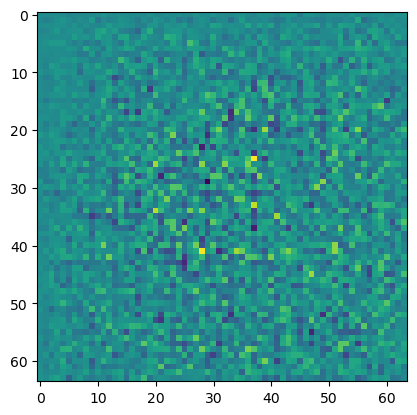

In [12]:
# Size of the random noise vector
SEED_SIZE = 100

# Size of the embedding vector for the captions
EMBEDDING_SIZE = 200

# Number of channels in the generated images
IMAGE_CHANNELS = 3

def build_generator_func(seed_size, embedding_size, channels):
    noise_input = layers.Input(shape=(seed_size,))
    embedding_input = layers.Input(shape=(embedding_size,))

    # Concatenate the noise and embedding inputs
    concatenated_inputs = layers.Concatenate()([noise_input, embedding_input])

    # Project and reshape the inputs
    x = layers.Dense(4 * 4 * 256)(concatenated_inputs)
    x = layers.Reshape((4, 4, 256))(x)

    # Block 1
    x = layers.Conv2DTranspose(128, 5, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Block 2
    x = layers.Conv2DTranspose(64, 5, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Block 3
    x = layers.Conv2DTranspose(32, 5, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Output block
    output = layers.Conv2DTranspose(channels, 5, strides=2, padding="same", activation="tanh")(x)

    return tf.keras.models.Model([noise_input, embedding_input], output)


def build_discriminator_func(input_shape, embedding_size):
    image_input = layers.Input(shape=input_shape)
    embedding_input = layers.Input(shape=(embedding_size,))

    # Block 1
    x = layers.Conv2D(64, 5, strides=2, padding="same")(image_input)
    x = layers.LeakyReLU()(x)

    # Block 2
    x = layers.Conv2D(128, 5, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Block 3
    x = layers.Conv2D(256, 5, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Concatenate with the embedding input
    x = layers.Concatenate()([x, embedding_input])

    # Output block
    output = layers.Dense(1, activation="sigmoid")(x)

    return tf.keras.models.Model([image_input, embedding_input], output)


# Build the generator and discriminator models
generator = build_generator_func(SEED_SIZE, EMBEDDING_SIZE, IMAGE_CHANNELS)
discriminator = build_discriminator_func((64, 64, IMAGE_CHANNELS), EMBEDDING_SIZE)

generator = build_generator_func(SEED_SIZE,EMBEDDING_SIZE, IMAGE_CHANNELS)
# Sample output from the Generator
noise = tf.random.normal([1, 100])
generated_image = generator((noise,caption_embeddings[5].reshape(1,200)), training=False)
plt.imshow(generated_image[0, :, :, 0])


In [13]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
decision = discriminator((generated_image,caption_embeddings[5].reshape(1,200)))
print(decision)

tf.Tensor([[0.44647765]], shape=(1, 1), dtype=float32)


In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text):
    real_loss = cross_entropy(tf.random.uniform(real_image_real_text.shape,0.8,1.0), real_image_real_text)
    fake_loss = (cross_entropy(tf.random.uniform(fake_image_real_text.shape,0.0,0.2), fake_image_real_text) + 
                 cross_entropy(tf.random.uniform(real_image_fake_text.shape,0.0,0.2), real_image_fake_text))/2

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)

In [16]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,captions,fake_captions):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE],dtype=tf.float32)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator((seed,captions), training=True)
    real_image_real_text = discriminator((images,captions), training=True)
    real_image_fake_text = discriminator((images,fake_captions), training=True)
    fake_image_real_text = discriminator((generated_images,captions), training=True)

    gen_loss = generator_loss(fake_image_real_text)
    disc_loss = discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text)
    # print(gen_loss)
    # print(disc_loss)

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [17]:
def save_images(cnt,noise,embeds):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)

  generated_images = generator.predict((noise,embeds))

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = "./Data/datasets/output"
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [18]:
# Function that executes trianing process
def train(train_dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  fixed_embed = save_images_embeddings

  start = time.time()

  for epoch in range(epochs):
    print("epoch start...")
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for batch in train_dataset[:-1]:
      # train_batch = training_data[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
      # caption_batch = captions[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
      train_batch = batch['images']
      caption_batch = batch['embeddings']
      
      fake_caption_batch = np.copy(caption_batch)
      np.random.shuffle(fake_caption_batch)
      
      t = train_step(train_batch,caption_batch,fake_caption_batch)
      # print(t)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
      # if image_batch%50 == 0:
      #   print(image_batch)
      # print("here")
    print("now")
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print(f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed,fixed_embed)
    
    generator.save(os.path.join(MODEL_PATH,"text_to_image_generator_biggan_character.h5"))
    discriminator.save(os.path.join(MODEL_PATH,"text_to_image_disc_biggan_character.h5"))
    print("model saved")

  elapsed = time.time()-start
  print ('Training time:', hms_string(elapsed))

In [19]:
train(list(train_dataset.as_numpy_iterator()), 2500)

2023-04-24 23:08:04.526879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [8100,64,64,3]
	 [[{{node Placeholder/_1}}]]
2023-04-24 23:08:04.527097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [8100,64,64,3]
	 [[{{node Placeholder/_1}}]]


epoch start...


2023-04-24 23:08:06.533536: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f279cc86b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-24 23:08:06.533563: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-04-24 23:08:06.536737: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-24 23:08:06.587830: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-24 23:08:06.646078: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


now
Epoch 1, gen loss=0.7965664267539978,disc loss=1.3539966344833374, 0:00:05.88
1/1 [==============================] - 0s 223ms/step
model saved
epoch start...
now
Epoch 2, gen loss=0.7940716743469238,disc loss=1.3515328168869019, 0:00:01.51
1/1 [==============================] - 0s 14ms/step
model saved
epoch start...
now
Epoch 3, gen loss=0.750542163848877,disc loss=1.3667792081832886, 0:00:01.52
1/1 [==============================] - 0s 14ms/step
model saved
epoch start...
now
Epoch 4, gen loss=0.7372181415557861,disc loss=1.3727551698684692, 0:00:01.50
1/1 [==============================] - 0s 14ms/step
model saved
epoch start...
now
Epoch 5, gen loss=0.7379433512687683,disc loss=1.3704911470413208, 0:00:01.51
1/1 [==============================] - 0s 15ms/step
model saved
epoch start...
now
Epoch 6, gen loss=0.7476532459259033,disc loss=1.3683987855911255, 0:00:01.50
1/1 [==============================] - 0s 14ms/step
model saved
epoch start...
now
Epoch 7, gen loss=0.7509569525

In [20]:
generator.load_weights((os.path.join(MODEL_PATH,"text_to_image_generator_biggan_character.h5")))
discriminator.load_weights((os.path.join(MODEL_PATH,"text_to_image_disc_biggan_character.h5")))

In [21]:
print(save_images_embeddings.shape)
# Printing the captions
save_images_captions

(28, 200)


['this is a large flower with red and yellow petals and a brown stem.\nthis flower has petals that are red with yellow tips and many purple stamen.\nthis is a flower with petals that are red toward the center and yellow around the edges.\nthis flower has petals that are red with yellow tips\nthis flower is pink and yellow in color, with petals that are yellow near the tips.\nthe stamen are dark red and cover a round center of the flower, surrounded by petals that are dark pink closest to the center and bright yellow furthest from the center of the flower.\nthis flower has many petals which are yellow on the edges and red near the middle.\nthis flower has red petals with yellow tips and purple stamen\nthis flower is pink and yellow in color, and has petals that are multi colored.\nthere are many dark red filaments surrounded by mostly red petals that turn to yellow at their tip.\n',
 'the petals on this plant are thin and are red with yellow tips\nthis flower has petals that are red wit

In [22]:
import gensim.downloader as api
glove_model = api.load('glove-twitter-200')

In [23]:
def test_image(text,num):
    test_embeddings = np.zeros((1,200),dtype=np.float32)

    x = text.lower()
    x = x.replace(" ","")
    count = 0
    for t in x:
        try:
            test_embeddings[0] += glove_model[t]
            count += 1
        except:
            #print(t)
            pass
    print(test_embeddings)
    if count != 0:
        test_embeddings[0] /= count
    else:
        return
    test_embeddings =  np.repeat(test_embeddings,[28],axis=0)
    noise = tf.random.normal([28, 100])
    save_images(num,noise,test_embeddings)

In [24]:
import IPython

[[ 8.8488274e+00 -6.3596711e+00  7.2783966e+00 -4.8506737e+00
  -2.8250167e+00 -7.1752608e-01 -2.9842371e+01 -5.5355630e+00
  -5.1024184e+00  1.5407039e+01 -6.9949632e+00 -1.1839816e+01
  -6.1694674e+00  4.8820624e+00 -7.1881633e+00 -6.1490531e+00
  -1.2922376e+01 -2.8915164e+00 -2.1194096e+01  1.6911091e+01
  -3.1744752e+00 -9.2550917e+00  2.4651951e+01  1.3993286e+01
   1.0590823e+01 -6.1763893e+01 -8.2646284e+00 -8.6736679e+00
   2.3534412e+01  1.3863489e+01 -1.4661982e+01 -9.3478432e+00
  -9.4071846e+00  5.6499273e-01  2.0107777e+01 -3.5452217e-01
  -7.8760881e+00 -6.5186172e+00 -2.4814938e+01  8.9871750e+00
  -4.9516762e+01  8.5098705e+00  1.7526638e+01 -4.2491198e-01
  -5.9351044e+00  8.2808876e-01  1.9504803e-01 -1.3530692e+01
   6.0162277e+00 -1.3190752e+01  1.0965534e+00  7.3055387e-01
  -1.0252500e+00  9.2277517e+00  3.5739169e+00  3.5809753e+00
   9.2840302e-01 -5.9725924e+00  2.7216303e+00 -9.6437597e+00
  -1.0331582e+01  8.2303888e-01  1.1920154e-02 -2.2911775e+00
  -4.426

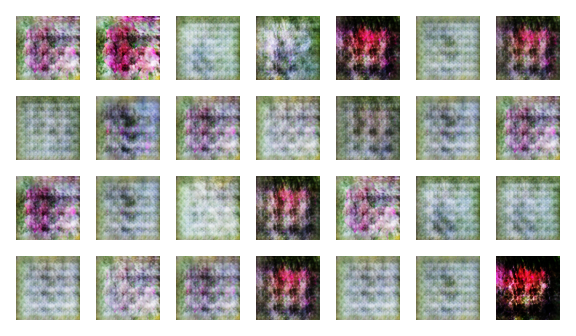

In [25]:
test_image("this flower is yellow in color with oval shaped petals", 1)
IPython.display.Image('./Data/datasets/output/train-1.png')

[[ 8.22277164e+00 -6.38372040e+00  1.05694065e+01 -1.35795224e+00
   8.46803963e-01  1.25016570e+00 -2.74883785e+01 -3.34806013e+00
  -6.40464830e+00  1.51644478e+01 -8.99650669e+00 -1.11330528e+01
  -6.83381844e+00  5.02891254e+00 -7.98462200e+00 -4.16463804e+00
  -1.49672270e+01 -4.62983847e+00 -2.64811401e+01  1.34910641e+01
  -5.22825432e+00 -1.01957712e+01  2.37989216e+01  1.26178827e+01
   1.36180658e+01 -5.83941994e+01 -1.12539072e+01 -1.09971218e+01
   2.49041138e+01  1.77721233e+01 -1.37809753e+01 -1.18160286e+01
  -8.96471310e+00  3.23135543e+00  1.73620777e+01 -2.82384396e+00
  -4.64361572e+00 -7.87279844e+00 -2.67733040e+01  8.80933380e+00
  -5.47006874e+01  9.50803471e+00  1.49716301e+01 -8.21754217e-01
  -1.90164495e+00 -2.18626595e+00 -1.85829893e-01 -1.21487751e+01
   6.27737856e+00 -1.12587910e+01  3.00489366e-01 -3.93683672e+00
   7.64945209e-01  9.67702770e+00  4.35121632e+00  2.59701180e+00
  -8.75631928e-01 -3.71301961e+00  4.31132364e+00 -8.89399433e+00
  -1.20718

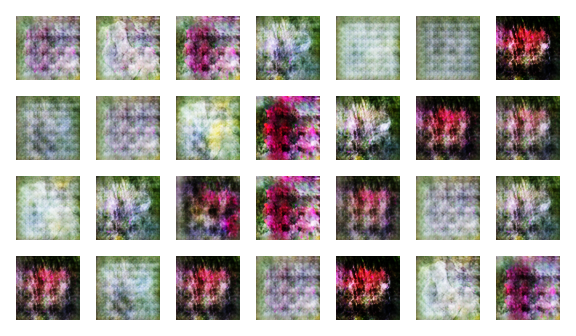

In [26]:
test_image("a large flower with pink and white petals and a brown stem", 2)
IPython.display.Image('./Data/datasets/output/train-2.png')

[[ 1.52909927e+01 -1.28069849e+01  1.49378605e+01 -4.85321236e+00
   2.67428935e-01  3.14435554e+00 -4.57190018e+01 -2.19099617e+00
  -9.97502995e+00  2.59762192e+01 -1.09425983e+01 -2.08544025e+01
  -5.01023388e+00  6.79689932e+00 -1.34349785e+01 -8.43373203e+00
  -2.09385185e+01 -5.56522512e+00 -3.43558846e+01  2.48458862e+01
  -1.15804749e+01 -1.60423145e+01  4.12253456e+01  2.05735474e+01
   1.98921814e+01 -1.06875961e+02 -1.59645958e+01 -1.80612259e+01
   3.67930641e+01  2.66524315e+01 -1.93091316e+01 -1.50169830e+01
  -1.36876040e+01  4.83596563e+00  2.92969570e+01 -2.42184687e+00
  -6.13065338e+00 -1.40137033e+01 -4.69602318e+01  1.34950857e+01
  -8.65271988e+01  1.40394793e+01  2.49463806e+01 -6.75539017e-01
  -6.36287022e+00 -4.07079744e+00  1.56993604e+00 -2.12532845e+01
   8.68747234e+00 -2.18533611e+01  4.27338934e+00 -2.49947023e+00
   1.97004318e+00  1.46664925e+01  7.15579891e+00  6.73068428e+00
  -1.38840914e+00 -7.89542437e+00  6.96860838e+00 -1.80266972e+01
  -2.17736

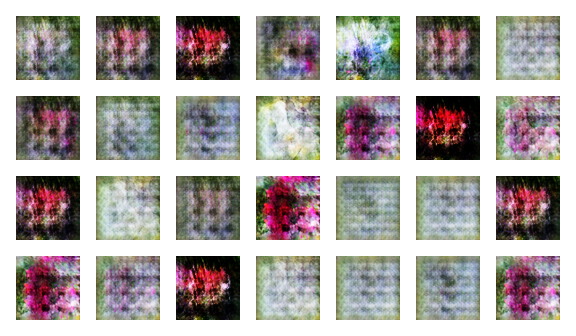

In [27]:
test_image("a group of red flowers with yellow tipped petals accompanied by maroon anther filaments", 3)
IPython.display.Image('./Data/datasets/output/train-3.png')

[[ 9.25072765e+00 -7.59446812e+00  1.08504028e+01 -3.42529923e-01
   4.83923912e-01  3.13025856e+00 -2.53708630e+01 -1.03465581e+00
  -4.40362597e+00  1.73660393e+01 -5.21336889e+00 -1.11681299e+01
  -4.09792137e+00  6.27080345e+00 -7.53264189e+00 -3.67393303e+00
  -1.03108501e+01 -1.53112090e+00 -1.51093969e+01  1.45346584e+01
  -7.91815281e+00 -8.76706982e+00  2.17216282e+01  8.35580921e+00
   1.15460215e+01 -5.67596931e+01 -1.03102102e+01 -1.12742014e+01
   1.93773918e+01  1.44732342e+01 -1.06059341e+01 -7.58658934e+00
  -5.81245804e+00  6.35053635e+00  1.55023031e+01 -1.72678506e+00
  -4.97729406e-02 -8.83852100e+00 -2.60058880e+01  6.57416391e+00
  -4.69405785e+01  7.86052942e+00  1.37449207e+01 -4.79893029e-01
  -3.54392433e+00 -2.39222074e+00  1.68264008e+00 -1.22998114e+01
   2.06347466e+00 -1.27086115e+01  2.62873721e+00 -3.56007862e+00
   2.01611114e+00  1.01048746e+01  5.17105627e+00  2.39302659e+00
  -1.94524539e+00 -4.11385345e+00  5.54633617e+00 -9.56639767e+00
  -1.33592

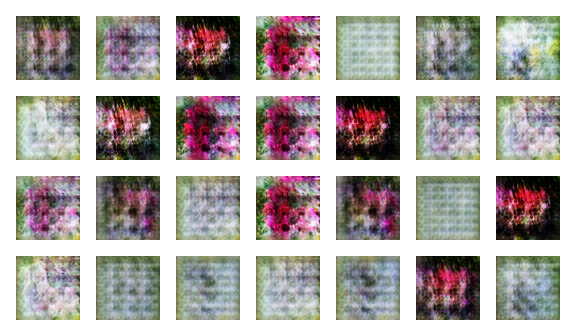

In [28]:
test_image("image of a white lily surrounded by green leaves.", 4)
IPython.display.Image('./Data/datasets/output/train-4.png')